# User input

You are free to change these parameters accordingly:

In [1]:
n = 3 # number of time series selected
mae = 0.32 # threshold error value as double
dataset = '/content/drive/My Drive/Colab Notebooks/Project3/nasdaq2007_17.csv' # path to the dataset
load = True # change to False if you want to train a new model
dir = '/content/drive/My Drive/Colab Notebooks/Project3/Saves/' # the directory to which the model will be save or from which it will be loaded
model_name = 'autoencoder2.h5' # file name of saved model (file must be of type .h5)

# Dataset loading and editing

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import pandas as pd
import numpy as np

print('Python version ' + sys.version)
print("---------------------------------------")

df = pd.read_csv(dataset, delimiter='\t', header=None)

df.rename(columns = {0:'id'}, inplace=True) #rename the first column to "id"
print(df.info())

Mounted at /content/drive
Python version 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Columns: 3651 entries, id to 3650
dtypes: float64(3650), object(1)
memory usage: 10.0+ MB
None


Set seed for reproductability:

In [3]:
import os
import random
import tensorflow

def reproducibleResults(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

reproducibleResults(12345)

# Model creation and training

Shuffle the dataset and the split it to train and test sets:

In [4]:
df.drop("id", axis=1, inplace=True)
df.sample(frac=1, random_state=1).reset_index(drop=True)

split_index = int(df.shape[0]*0.9)

train = df.head(split_index)
test = df.tail(df.shape[0]-split_index).reset_index(drop=True)
print(train.shape, test.shape)

(323, 3650) (36, 3650)


Transpose the sets for our convinience:

In [5]:
train = train.transpose()
test = test.transpose()
print(test.head())

       0       1       2       3   ...      32      33      34      35
1  11.440  27.255  16.375  16.111  ...  36.388  8.2660  46.395  47.669
2  11.660  26.262  16.528  15.638  ...  35.203  8.3172  45.815  46.668
3  11.825  26.171  16.520  15.618  ...  35.707  8.2781  42.181  46.570
4  11.275  26.152  15.829  15.747  ...  35.104  8.3591  41.582  46.974
5  10.780  27.464  15.796  15.884  ...  36.282  8.2781  43.444  47.004

[5 rows x 36 columns]


Perform scaling:

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

for i in range(train.shape[1]):
  curr_ts = train[i].to_numpy()
  curr_ts = curr_ts.reshape(-1,1)
  train[i] = scaler.fit_transform(curr_ts)

for i in range(test.shape[1]):
  curr_ts = test[i].to_numpy()
  curr_ts = curr_ts.reshape(-1,1)
  test[i] = scaler.transform(curr_ts)

print(train.shape, test.shape)

(3650, 323) (3650, 36)


Split to X and y:

In [7]:
import numpy as np

def create_dataset(X, time_steps=1, lag=1):
    Xs, ys = [], []
    for j in range(len(X.columns)):
      for i in range(0, len(X) - time_steps, lag):
          v = X[j].iloc[i:(i + time_steps)].values
          Xs.append(v)
          ys.append(X[j].iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
WINDOW = 50
LAG = 10

# reshape to (samples, window, n_features)

X_train, y_train = create_dataset(train, WINDOW, LAG)
X_test, y_test = create_dataset(test, WINDOW)

X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

print(X_train.shape)
print(y_train.shape)

(116280, 50, 1)
(116280,)


In [9]:
print(X_test.shape)
print(y_test.shape)

(129600, 50, 1)
(129600,)


Train the model (if needed):

In [10]:
import keras
import time

if load == False:
  start = time.time()
  model = keras.models.Sequential([
  keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])),
  keras.layers.Dropout(0.2),
  keras.layers.RepeatVector(n = X_train.shape[1]),
  keras.layers.LSTM(100, return_sequences=True),
  keras.layers.Dropout(0.2),
  keras.layers.TimeDistributed(keras.layers.Dense(units = X_train.shape[2]))
  ])

  model.compile(optimizer = 'adam', loss = 'mae')

  history = model.fit(X_train, y_train, epochs = 10, batch_size=2048, validation_split=0.1)
  end = time.time()
  print("Time needed: ", (end-start)/60)

Epoch 1/10
52/52 [==============================] - 246s 5s/step - loss: 0.2239 - val_loss: 0.2122
Epoch 2/10
52/52 [==============================] - 244s 5s/step - loss: 0.2104 - val_loss: 0.2110
Epoch 3/10
52/52 [==============================] - 263s 5s/step - loss: 0.2096 - val_loss: 0.2108
Epoch 4/10
52/52 [==============================] - 265s 5s/step - loss: 0.2096 - val_loss: 0.2109
Epoch 5/10
52/52 [==============================] - 284s 5s/step - loss: 0.2091 - val_loss: 0.2108
Epoch 6/10
52/52 [==============================] - 290s 6s/step - loss: 0.2090 - val_loss: 0.2108
Epoch 7/10
52/52 [==============================] - 297s 6s/step - loss: 0.2089 - val_loss: 0.2102
Epoch 8/10
52/52 [==============================] - 290s 6s/step - loss: 0.2088 - val_loss: 0.2101
Epoch 9/10
52/52 [==============================] - 291s 6s/step - loss: 0.2087 - val_loss: 0.2103
Epoch 10/10
52/52 [==============================] - 294s 6s/step - loss: 0.2087 - val_loss: 0.2101
Time need

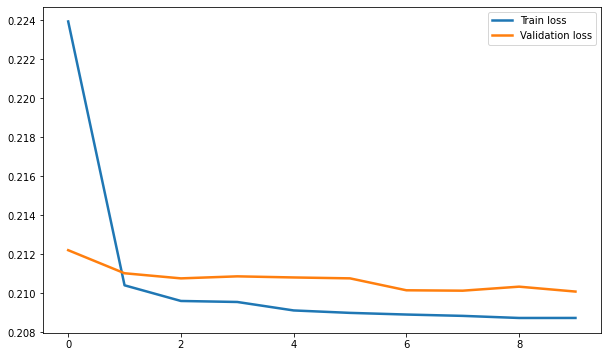

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

if load == False:
  plt.figure(figsize=(10,6))
  plt.plot(history.history['loss'], label='Train loss', linewidth=2.5)
  plt.plot(history.history['val_loss'], label='Validation loss', linewidth=2.5)
  plt.legend();

Save model if needed:

In [12]:
if load == False:
  !pip install h5py pyyaml
  full_path = dir + model_name
  model.save(full_path)

Load model if needed:

In [13]:
if load == True:
  full_path = dir + model_name
  model = keras.models.load_model(full_path)
  model.summary()

# Making predictions and finding anomalies

This step may take some time:

In [14]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

Th plot bellow shows that most of the loss is lower than 0.3 (for our dataset), making 0.3 a good threshold to use for detecting anomalies.

[]

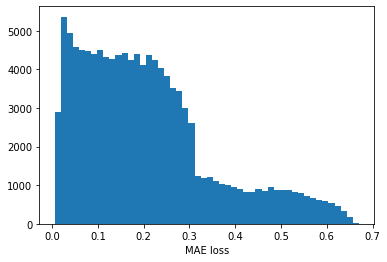

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train_mae_loss, bins=50)
plt.gca().set(xlabel="MAE loss")
plt.plot()

This step may take some time:

In [16]:
X_test_pred = model.predict(X_test)

In [17]:
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

## Choosing which series to plot

We are making predictions for all the time series of the test set and so you can choose to plot any one of them by changing the series_num variable bellow (value must be an integer in [1, n], were n is the number of time series in the current test set and so it is __n=36__ in this example):

In [18]:
series_num = 34

In [19]:
series_index = series_num-1
num_values = (test.shape[0]-WINDOW)
series_pred = X_test_pred[series_index*num_values : series_index*num_values+num_values]

test_score_df = pd.DataFrame()
test_score_df['loss'] = test_mae_loss[series_index*num_values:series_index*num_values+num_values].squeeze()
test_score_df['threshold'] = mae
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

test_score_df['price'] = y_test[series_index*num_values:series_index*num_values+num_values]

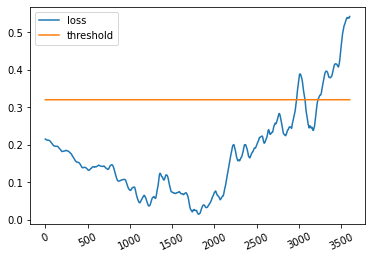

In [20]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [21]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,price
2972,0.321991,0.32,True,0.726884
2973,0.324274,0.32,True,0.731301
2974,0.326917,0.32,True,0.720122
2975,0.329755,0.32,True,0.705363
2976,0.332383,0.32,True,0.705363


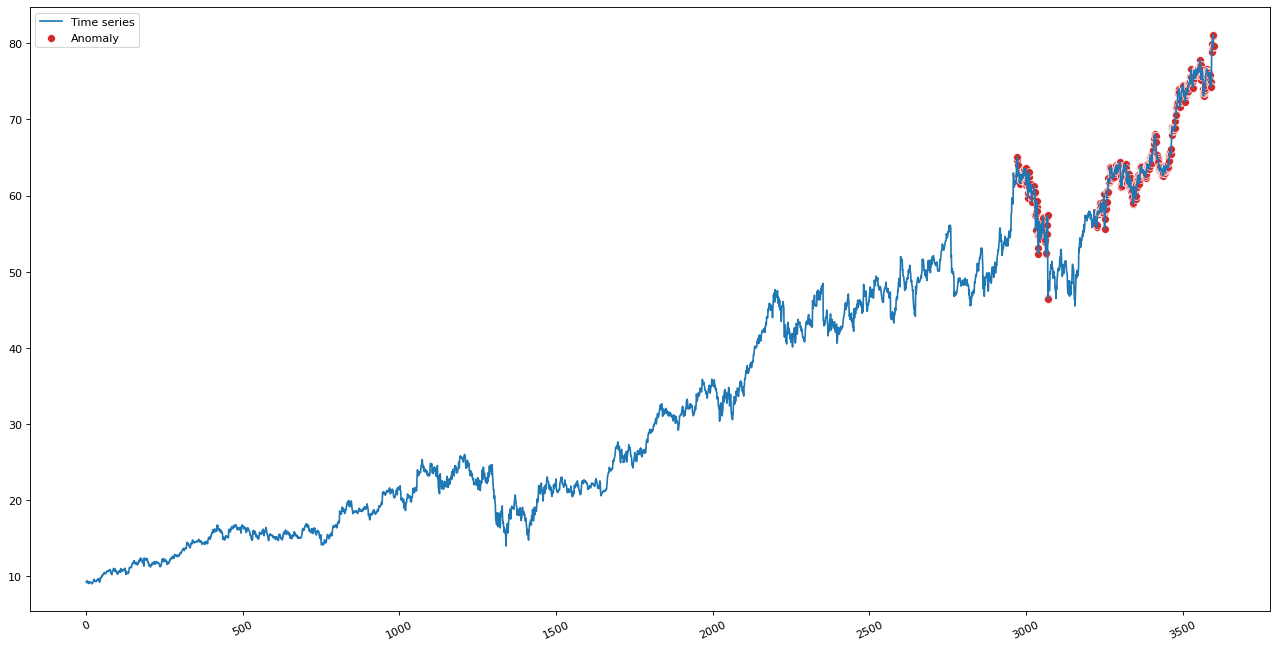

In [22]:
from matplotlib.pyplot import figure
import seaborn as sns

to_plot = scaler.inverse_transform(np.array(test_score_df['price'])[:, np.newaxis])

figure(figsize=(20, 10), dpi=80)

scores_np = test_score_df['price'].values
scores_np = scores_np.reshape(-1, 1)
plt.plot(
  scaler.inverse_transform(scores_np),
  label='Time series'
);

anomalies_np = anomalies['price'].values
anomalies_np = anomalies_np.reshape(-1, 1)
if anomalies_np.shape[0]>0:
  sns.scatterplot(
    x=anomalies.index,
    y=scaler.inverse_transform(anomalies_np).squeeze(),
    color=sns.color_palette()[3],
    s=50,
    label='Anomaly'
  )
plt.xticks(rotation=25)
plt.legend();